## Intro to information extraction from text

Most of the data we've looked at so far has been *structured*, meaning essentially that the data looked like a table or Excel spreadsheet. Not all data looks like that, however.  Human readable text is an extremely common *unstructured* data source.  From the text of a webpage, tweet, or document, businesses want to perform things like:

* sentiment analysis
* document summarization
* document clustering
* document recommendation

Later in MSAN 692, we'll learn how to extract the text from webpages or pieces of webpages such as the bestseller list at Amazon. For now, we can play with some prepared text files.

Text analysis uses words as data rather than numbers, which means *tokenizing* text; i.e., splitting the text string for a document into individual words. This problem is actually much harder than you might think.  For example, if we split the document text on the space character, then "San Francisco" would be split into two words.  For our purposes here, that'll work just fine. See [Tokenization in this excellent information retrieval book](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) for more information.

<img src="figures/wordcloud.png" width="200" align="right">The goal of this lecture-lab is to get familiar with tokenizing text and how to extract some basic data, such as word frequency. To visualize information extracted from a document, we'll use *word clouds* like the image to the right that emphasize words according to their frequency.

## Tokenizing a document

Let's use an article on [Istanbul](https://github.com/parrt/msds692/blob/master/notes/data/IntroIstanbul.txt) as our text file and then figure out how to get an appropriate list of words out of it.

In [1]:
! head data/IntroIstanbul.txt


  
  
    
      
        The City and ITS People
        Istanbul is one of the worlds most venerable cities. Part
        of the citys allure is its setting, where Europe faces Asia acr­oss
        the winding turquoise waters of the Bosphorus, making it the only city
        in the world to bridge two continents.


In [Loading files](files.md), we learned how to read the contents of such a file into a string and split it on the space character:

In [2]:
with open('data/IntroIstanbul.txt') as f:
    contents = f.read() # read all content of the file
words = contents.split()
print(words[:25])    # print first 25 words

['The', 'City', 'and', 'ITS', 'People', 'Istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities.', 'Part', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting,', 'where', 'Europe', 'faces']


That looks more like it although it is still not very clean.  We should also strip punctuation marks. Here's a slower way to do it using a filter pattern with a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [3]:
import string
contents = [c for c in contents if c not in string.punctuation]
contents = ''.join(contents)
words = contents.split()
print(words[:25])

['The', 'City', 'and', 'ITS', 'People', 'Istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities', 'Part', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting', 'where', 'Europe', 'faces']


Some of the words are capitalized.  What we need, is all words normalized so that `people` and `People` are consider the same word etc...

**Exercise**:  Implement another filter pattern to convert the words to lowercase using `lower()`. E.g., `'The'.lower()` is `'the'`.

Here's one way to do it:

In [4]:
words = [w.lower() for w in words]
print(words[:25])

['the', 'city', 'and', 'its', 'people', 'istanbul', 'is', 'one', 'of', 'the', 'worlds', 'most', 'venerable', 'cities', 'part', 'of', 'the', 'citys', 'allure', 'is', 'its', 'setting', 'where', 'europe', 'faces']


That's not the best we can do. For example "faces" and "face" should be the same. Let's *stem* the words: 

In [5]:
! pip install -q -U nltk

In [6]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
stemmed = [stemmer.stem(w) for w in words]
print(stemmed[:45])

['the', 'citi', 'and', 'it', 'peopl', 'istanbul', 'is', 'one', 'of', 'the', 'world', 'most', 'vener', 'citi', 'part', 'of', 'the', 'citi', 'allur', 'is', 'it', 'set', 'where', 'europ', 'face', 'asia', 'acr\xadoss', 'the', 'wind', 'turquois', 'water', 'of', 'the', 'bosphoru', 'make', 'it', 'the', 'onli', 'citi', 'in', 'the', 'world', 'to', 'bridg', 'two']


## Computing word frequencies

Let's create a [bag of words](notes/dict.ipynb) representation. My work plan would have a description like "Walk through the words in a document, updating a dictionary that holds the count for each word." The plan pseudocode would have a loop over the words whose body incremented a count in a dictionary

1. let wfreqs be an empty dictionary mapping words to word counts
2. for each word w in words:<br>if w not in wfreqs, let wfreqs[w] = 1.<br>Otherwise add one to wfreqs[w].

My code implementation would look like the following.

In [7]:
from collections import defaultdict

wfreqs = defaultdict(int) # missing entries yield value 0
for w in stemmed:
    wfreqs[w] = wfreqs[w] + 1
print(wfreqs['ottoman'])
print(wfreqs['the'])

6
123


Computing the frequency of elements in a list is common enough that Python provides a built-in data structure called a `Counter` that will do this for us:

In [8]:
from collections import Counter
ctr = Counter(stemmed)
print(ctr['ottoman'])
print(ctr['the'])

6
123


That data structure is nice because it can give the list of, say, 10 most common words:

In [9]:
print(ctr.most_common(10))

[('the', 123), ('of', 55), ('and', 40), ('citi', 19), ('to', 19), ('in', 16), ('is', 15), ('a', 13), ('it', 10), ('istanbul', 9)]


### Exercise

Extract the most common 10 words from `ctr` (i.e., not the tuples).

In [10]:
print([p[0] for p in ctr.most_common(10)])

['the', 'of', 'and', 'citi', 'to', 'in', 'is', 'a', 'it', 'istanbul']


## Word clouds

Python has a nice library called `wordcloud` (we use this in the SF Police data lab) we can use to visualize the relative frequency of words. It should already be installed in your Anaconda Python directory, but if not use the command line to install it:

```bash
$ pip install wordcloud
```

The key elements of the following code are the creation of the `WordCloud` and calling `fit_words()` with a dictionary (type `dict`) of word-freq associations, `wfreq`.

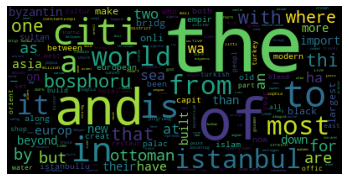

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud()
wordcloud.fit_words(ctr)

fig=plt.figure(figsize=(6, 6))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

That's kind of busy will all of those words in there, so let's focus on the top 30 words. To do that we will call `most_common()`, which gives us a list of tuples. Because `fit_words()` it requires a `dict`, we convert the most common word list into a dictionary:

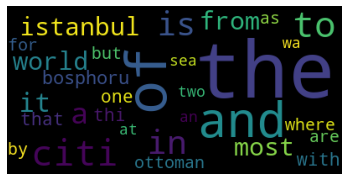

In [12]:
# Get 30 most common word-freq pairs then convert to dictionary for use by WordCloud
wtuples = ctr.most_common(30)
wdict = dict(wtuples)

wordcloud = WordCloud()
wordcloud.fit_words(wdict)

fig=plt.figure(figsize=(6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

That looks better but it looks like common English words like "the" and "of" are dominating the visualization. To focus on the words most relevant to the document, let's filter out such so-called English *stop words*. [scikit-learn](http://scikit-learn.org/stable/), a machine learning library you will become very familiar with in future classes, provides a nice list of stop words we can use:

In [13]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
english = list(ENGLISH_STOP_WORDS) # Convert to a list so I can grab a subset
print(english[:25])                # Print 25 of the words

['those', 'whoever', 'inc', 'few', 'four', 'give', 'myself', 'amount', 'up', 'us', 'whereas', 'beside', 'only', 'fill', 'himself', 'together', 'per', 'sincere', 'bottom', 'keep', 'so', 'there', 'we', 'side', 'whenever']


### Exercise 

Filter out the English stop words from the `words` list we computed above and reset `wfreqs` to a `Counter` based off this filtered list.

In [14]:
contents = [c for c in contents if c not in string.punctuation]
contents = ''.join(contents)
words = contents.split()
words = [w.lower() for w in words]
goodwords = [w for w in words if w not in ENGLISH_STOP_WORDS]
stemmer = PorterStemmer()
stemmed = [stemmer.stem(w) for w in goodwords]
goodctr = Counter(stemmed)
print(goodctr.most_common(10))

[('citi', 19), ('istanbul', 9), ('world', 9), ('bosphoru', 8), ('ottoman', 6), ('sea', 5), ('europ', 4), ('asia', 4), ('byzantin', 4), ('import', 4)]


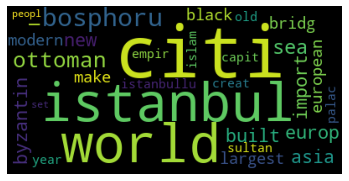

In [15]:
wtuples = goodctr.most_common(30)
wdict = dict(wtuples)

wordcloud = WordCloud()
wordcloud.fit_words(wdict)

fig=plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Exercise

Add Porter stemming to the previous exercise

You can play around with the list of stop words to remove things like "important" and others to really get the key words to pop out. There is a technique to automatically damp down common English words called [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which we will learn about soon in this class.

## Converting non-ASCII char

We should clean up the text extracted from the HTML so that the non-ASCII characters are stripped or converted.

In [16]:
text = "I need ¢ and £ and ¥"
print(text)
text = [c for c in text if ord(c)<=127]
text = ''.join(text)
print(text)

I need ¢ and £ and ¥
I need  and  and 


## Stripping char beyond 255 from commandline

If there are characters within the file that are non-ASCII and larger than 255, we can convert the file using the command line. Here's a simple version of the problem I put into file `/tmp/foo.html`:

```html
<html>
<body>
གྷ
</body>
</html>
```

I deliberately injected a Unicode code point > 255, which requires two bytes to store.  Most of the characters require just one byte. Here is first part of file:

```bash
$ od -c -t xC /tmp/t.html
0000000    <   h   t   m   l   >  \n   <   b   o   d   y   >  \n   གྷ  **
           3c  68  74  6d  6c  3e  0a  3c  62  6f  64  79  3e  0a  e0  bd
...
```           

Here is how you could strip any non-one-byte characters from the file before processing:

```bash
$ iconv -c -f utf-8 -t ascii /tmp/foo.html 
<html>
<body>

</body>
</html>
```

## Summary

Text files are an unstructured data source that we typically represent as a bag of words. A bag of words representation is a set of associations mapping words to their frequency or count. We typically use a dictionary data structure for bag of words because dictionary lookup is extremely efficient, versus linearly scanning an entire list of associations. We used word clouds to visualize the relative frequency of words in a document. 

The data structures and techniques described in this lecture-lab form the basis of natural language processing (NLP).